In [1]:
import numpy as np
import scipy
import scipy.stats as sps
import pandas as pd
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_validate, LeaveOneOut
from sklearn.neighbors import KernelDensity

%matplotlib inline

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

## Task 1: Bayesian inference with MCMC

We will consider a simple case of Bayesian inference for the unknown mean parameter of a Normal distribution. A series of values $\boldsymbol{X}^{(n)} = X_1, X_2, \dots X_n$ is sampled **independently** from a Normal distribution and we know its variance in advance, but are unsure about the mean. We assign a prior distribution to this unknown mean and would like to infer its posterior. We are also interested in predicting future observations $X$, so we would like to obtain its posterior predictive distribution as well.
$$\mu \sim \mathcal{N}(\mu_0, \sigma_0^2)$$
$$X_i | \mu \sim \mathcal{N}(\mu, \sigma^2), \; i=1 \dots n.$$

In [2]:
np.random.seed(31337)

true_mu = 3.0
true_std = 0.3
N = 20

prior_mu = 0.
prior_std = 1.

X = np.random.normal(true_mu, true_std, 20)

### Task 1.1: implement analytical posterior (1 point)

$$p(\mu | \boldsymbol{X}^{(n)}) = \frac{p(\boldsymbol{X}^{(n)} | \mu) p(\mu)}{p(\boldsymbol{X}^{(n)})}, \label{eq1} \tag{1}$$
$$p(\boldsymbol{X}^{(n)}) = \int p(\boldsymbol{X}^{(n)}, \mu) d\mu$$
For our simple case it is actually possible to derive the exact posterior distibution of the mean analytically. Posterior distiribution of $\mu$ will also be Normal, but with different parameters that will depend on the observed sample and prior parameters. Refer to https://en.wikipedia.org/wiki/Conjugate_prior for the exact formulas and implement them in the following function:

In [3]:
def analytical_posterior_pdf(x, samples, sigma, mu_0, sigma_0):
    """
    Probability density of the analytical posterior for the Normal model with known variance
    
    :param x: point(s) where to evaluate the density
    :param samples: observed samples
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p(mu | samples)(x)
    """
    
    # Your code code to derive the parameters
    r = 1 / (1 / sigma_0**2 + len(samples) / sigma**2)
    
    mu_p = r * (mu_0 / sigma_0**2 + np.sum(samples) / sigma**2)
    sigma_p = r
        
    
    return scipy.stats.norm(mu_p, sigma_p).pdf(x)

Plot the resulting analytical posterior for the given observed sample, standard deviation of $X_i$ and prior parameters.

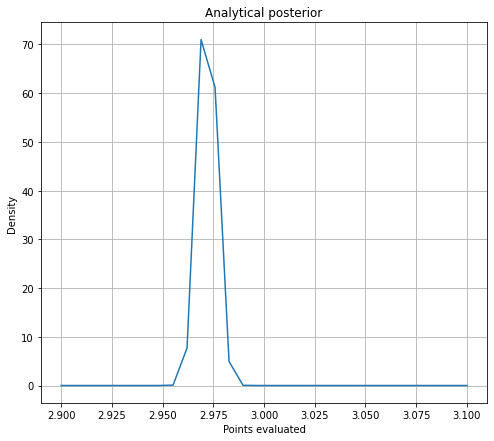

In [4]:
plt.figure(figsize = (8, 7))
y = np.linspace(2.9, 3.1, 30)
#np.arange(10)
plt.plot(y, analytical_posterior_pdf(y, X, true_std, prior_mu, prior_std))
plt.title('Analytical posterior')
plt.xlabel('Points evaluated')
plt.ylabel('Density')
plt.grid()
plt.show()

### Task 1.2: Metropilis-Hastings algorithm (2 points)

In more complex models it is usually infeasible to derive the exact formula for the posterior density. In the equation (1), the numerator contains easy to evaluate terms: prior and likelihood, while the denominator is rather hard to find. This means that we know our posterior only up to a constant multiplicative term. We will have to resort to approximations. Previously in the course we have studied methods to estimate the unknown density from samples. If we could sample from this unknown posterior, we might be able to approximate in using a histogram or a kernel method.

This is precisely the goal of MCMC methods. We will construct a Markov chain that will eventually produce samples from our distribution of interest - the posterior.


Markov chain is a sequence of random variables $Y_1, Y_2, \dots$ with the following property:
$$p(Y_k | Y_{k-1}, Y_{k-2}, \dots, Y_2, Y_1) = p(Y_k | Y_{k-1}),$$
wich means that subsequent values ($Y_k$) do not depend on the whole history of the sequence if the previous value ($Y_{k-1}$) is given.

We want to start with our chain from the prior distribution $Y_1 \sim p(\mu)$ and eventually converge to the posterior $Y_k \sim p(\mu | \boldsymbol{X}^{(n)})$. In order to achieve this, we need to define the transition probabilities $p(Y_k | Y_{k-1})$ in a special way. Intuitevely, it will depend on the prior and posterior in some way and there may be different possibilities.

We will describe one way to do it, namely Metropilis-Hastings algorithm with a random walk proposal. It was introduced in lecture 10, slides 19-22. We will use it to draw a sequence of samples from a special markov chain that satisfies our requirements.

Let $T$ be the number of steps we decided to take from the chan. For our example model and using our notation the algorithm outilines as follows:

1. Start by sampling $Y_1$ from the prior $p(\mu)$
2. Repeat for each $k$ form 1 to T:
3. Construct the next sample $Y_{k+1}$ given the previous sampled value $Y_k$:
4. $Y_{k+1} = Y_{k} + Z_{k+1}$, where $Z_{k+1} \sim \mathcal{N}(0, \sigma_{step}^2)$ (we take a sample)
5. We need to decide whether to make the transition $Y_k \rightarrow Y_{k+1}$ (accept or reject our *proposed* new value $Y_{k+1}$):
6. Accept the new sample with probability $\min \left\{1, \frac{p(\boldsymbol{X}^{(n)} | \mu = Y_{k+1}) p(\mu = Y_{k+1})}{p(\boldsymbol{X}^{(n)} | \mu = Y_{k}) p(\mu = Y_{k})}\right\}$, otherwise let $Y_{k+1} = Y_k$

Notice that our acceptance probability equals the ratio of the **posterior** probabilities: $\frac{p(\mu=Y_{k+1} | \boldsymbol{X}^{(n)})}{p(\mu=Y_k | \boldsymbol{X}^{(n)})}$, since the denominator in formula (1) does not depend on $\mu$. This allows us to skip the hard part of taking the integral. 

*You may need to tune the $\sigma_{step}$ parameter.

In [5]:
def acceptance_prob(y_new, y_old, samples, sigma, mu_0, sigma_0):
    """
    Calculate acceptance probability in Metropilis-Hastings step for the Normal model with known variance
    :param y_new: proposed value (corresponds to Y_{k+1})
    :param y_old: previous value (corresponds to Y_k)
    :param samples: observed data (X^(n))
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p, acceptance probability
    """
    # analytical_posterior_pdf(x, samples, sigma, mu_0, sigma_0) = p(mu | samples)(x) =  p(x = mu | samples)
    # Your code here
    a = analytical_posterior_pdf(y_new, samples, sigma, mu_0, sigma_0)
    b = analytical_posterior_pdf(y_old, samples, sigma, mu_0, sigma_0)
    r = a / b
    
    p = min(1, r)
    return p

In [6]:
T = 2000

sigma_step = 0.5

Y = np.empty(T)

Y[0] = np.random.normal(prior_mu, prior_std)

for i in tqdm(range(1, T)):
    # Your code here
    Z = np.random.normal(0, sigma_step**2)
    Y_next = Y[i - 1] + Z
    
    if np.random.rand() < acceptance_prob(Y_next, Y[i - 1], X, true_std, prior_mu, prior_std):
        Y[i] = Y_next
    else:
        Y[i] = Y[i - 1]
    #pass

### Task 1.3: Visualize the results (1 point)
We have obtained a single trajectory of our Markov chain. The tsarting portion the obtained values may be different from the samples of the actual posterinir. After the so-called 'burn-in' or 'warmup' phase the distribution should become stationary and connverge to the true posterior. Time spent before this convergence occurs is usually called *mixing time*, and it is hard to estimate in practical situations.

1. Plot your trajectory using line chart: x-axis will be the timestep number and y-axis the sampled value

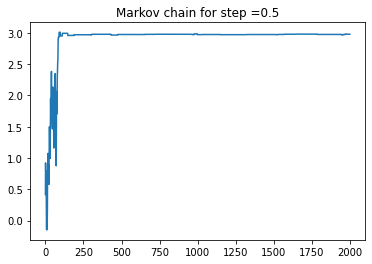

In [7]:
timestep = np.arange(T)
plt.plot(timestep, Y)
plt.title('Markov chain for step =' + str(sigma_step))
plt.show()

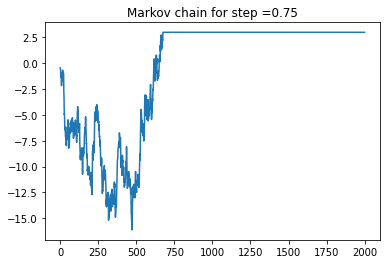

In [8]:
T = 2000
sigma_step = 0.75
Y = np.empty(T)
Y[0] = np.random.normal(prior_mu, prior_std)
for i in tqdm(range(1, T)):
    Z = np.random.normal(0, sigma_step**2)
    Y_next = Y[i - 1] + Z
    
    if np.random.rand() < acceptance_prob(Y_next, Y[i - 1], X, true_std, prior_mu, prior_std):
        Y[i] = Y_next
    else:
        Y[i] = Y[i - 1]
    
timestep = np.arange(T)
plt.plot(timestep, Y)
plt.title('Markov chain for step =' + str(sigma_step))
plt.show()

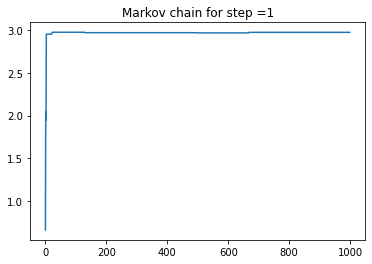

In [9]:
T = 1000
sigma_step = 1
Y = np.empty(T)
Y[0] = np.random.normal(prior_mu, prior_std)
for i in tqdm(range(1, T)):
    Z = np.random.normal(0, sigma_step**2)
    Y_next = Y[i - 1] + Z
    
    if np.random.rand() < acceptance_prob(Y_next, Y[i - 1], X, true_std, prior_mu, prior_std):
        Y[i] = Y_next
    else:
        Y[i] = Y[i - 1]
    
timestep = np.arange(T)
plt.plot(timestep, Y)
plt.title('Markov chain for step =' + str(sigma_step))
plt.show()

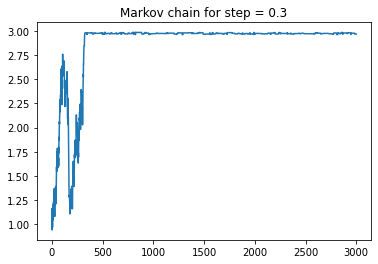

In [10]:
### ! This example often does not converge due to the small sigma_step !

T = 3000
sigma_step = 0.3
Y = np.empty(T)
acceptance_list = np.empty(T)
acceptance_list[0] = 0

Y[0] = np.random.normal(prior_mu, prior_std)
for i in tqdm(range(1, T)):
    Z = np.random.normal(0, sigma_step**2)
    Y_next = Y[i - 1] + Z
    
    if np.random.rand() < acceptance_prob(Y_next, Y[i - 1], X, true_std, prior_mu, prior_std):
        acceptance_list[i] = acceptance_list[i - 1] + 1
        Y[i] = Y_next
    else:
        Y[i] = Y[i - 1]
        acceptance_list[i] = acceptance_list[i - 1]
    
timestep = np.arange(T)
plt.plot(timestep, Y)
plt.title('Markov chain for step = ' + str(sigma_step))
plt.show()

2. Plot the acceptance probability: how many proposed steps were accepted on average at given timestep (use sliding window or exponential moving average). Does it change over time? (You may need to save additional info during sampling in the previous part)

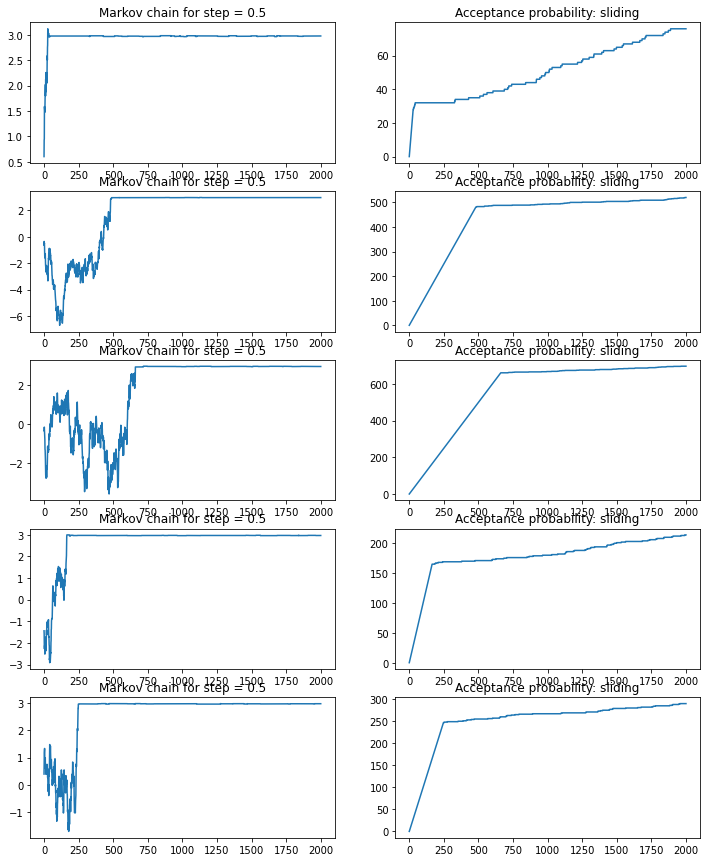

In [11]:
iters = 5
f, axes = plt.subplots(iters, 2, figsize = (12, 15))
for j in range(iters):
    T = 2000
    sigma_step = 0.5
    Y = np.empty(T)
    acceptance_list = np.empty(T)
    acceptance_list[0] = 0

    Y[0] = np.random.normal(prior_mu, prior_std)
    for i in range(1, T):
        Z = np.random.normal(0, sigma_step**2)
        Y_next = Y[i - 1] + Z

        if np.random.rand() < acceptance_prob(Y_next, Y[i - 1], X, true_std, prior_mu, prior_std):
            acceptance_list[i] = acceptance_list[i - 1] + 1
            Y[i] = Y_next
        else:
            Y[i] = Y[i - 1]
            acceptance_list[i] = acceptance_list[i - 1]

    timestep = np.arange(T)
    axes[j][0].plot(timestep, Y)
    axes[j][0].set_title('Markov chain for step = ' + str(sigma_step))
    axes[j][1].plot(timestep, acceptance_list)
    axes[j][1].set_title('Acceptance probability: sliding')

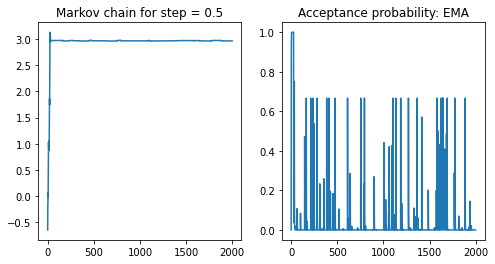

In [12]:
T = 2000
f, axes = plt.subplots(1, 2, figsize = (8, 4))
sigma_step = 0.5
probs = np.empty(T)
Y = np.empty(T)
Y[0] = np.random.normal(prior_mu, prior_std)

for i in tqdm(range(1, T)):
    Z = np.random.normal(0, sigma_step**2)
    Y_next = Y[i - 1] + Z
    probs[i] = acceptance_prob(Y_next, Y[i - 1], X, true_std, prior_mu, prior_std)
    if np.random.rand() < probs[i]:
        Y[i] = Y_next
    else:
        Y[i] = Y[i - 1]


probs = pd.DataFrame(probs)
ewm = probs.ewm(com=0.5).mean()[0]       
timestep = np.arange(T)

axes[0].plot(timestep, Y)
axes[0].set_title('Markov chain for step = ' + str(sigma_step))
axes[1].plot(timestep, ewm)
axes[1].set_title('Acceptance probability: EMA')
f.show()

##### We can observe that the convergence becomes better with lower values of acceptance probability (in my case it is the total amount of accepted $Z$ for current time step, so the linear order represents constant amount of acceptance per fixed time period). 
##### If it has linear dependency or higher, than 1, degree of variable, there will be no convergence (which is explainable, since when often accepting we keep changing the value instead of making it steady which means convergence).
##### But if the graph of probability changes close to order of $\sqrt{x}$ there comes a covergence fast.
##### From the EMA we can come to the same conclusion - when the acceptance probability is high, elements change chaotically but when its mean become close to $0.5$, there comes a convergence.

3. When do you think the 'mixing' occured? (Approximately)

#### Apparently, the larger sigma_step is, the faster mixing occures. But for a fixed step size, the values of mixing time can change significantly. 
#### For some small steps (like 0.3) it may not occur even in 5000 iterations. 
#### With increase of sigma_step mixing time decreases (I got approximately linerar dependence, but it may wrong be due to small number of trials). For sigma_step values starting from $0.5$, $500$ iterations are usually enough for convergence.

### Task 1.4: Approximate posterior (1 points)

Now we have determined the part of our trajectory that converjed to our target distribution (you can use your guess from the previous task or just designate first half the trajectory for mixing). We will work with the remaing part to approximate the posterior.

1. Plot the histogram and kernel density estimator of the posterior using the samples from your MCMC run
2. Unfortunately, the samples that we obtained are not independent: due to the nature of our proposal step they are correlated. We can try to aleviate this effect by dropping some of the samples. Use only every 3rd (or 4th, 5th) obtained sample and display it on the same plot. Is it different?
3. Add theoretical posterior from part 1 to the same plot. Is it close to our estimate?

In [35]:
T = 2000
sigma_step = 0.6
idx_conv = -1
found_index = False
eps = 0.1

while True:
    Y = np.empty(T)
    Y[0] = np.random.normal(prior_mu, prior_std)
    for i in range(1, T):
        Z = np.random.normal(0, sigma_step**2)
        Y_next = Y[i - 1] + Z

        if np.random.rand() < acceptance_prob(Y_next, Y[i - 1], X, true_std, prior_mu, prior_std):
            Y[i] = Y_next
        else:
            Y[i] = Y[i - 1]
        if (found_index == False and np.abs(Y[i] - 3.) < eps/10):
            idx_conv = i
            found_index = True
            
    if (np.abs(Y[1900] - 3.) < eps):
        break
    
#timestep = np.arange(T)
#plt.plot(timestep, Y)
#plt.title('Markov chain for step =' + str(sigma_step))
#plt.show()

x_ar = np.linspace(2.8, 3.2, 100)
x_ar = np.array(x_ar)

if (idx_conv != -1):
    print(idx_conv)
    Y_cut = Y[idx_conv:]
else:
    Y_cut = Y[500:]

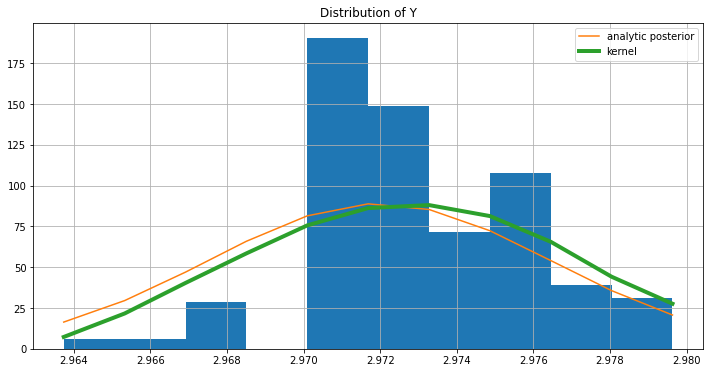

In [36]:
plt.figure(figsize=(12, 6))

c, bins, _ = plt.hist(Y_cut, density=True)
post = analytical_posterior_pdf(bins, X, true_std, prior_mu, prior_std)
#hist, edges = np.histogram(Y[500:], range = (np.min(Y[500:]), np.max(Y[500:])), density = True)
plt.plot(bins, post, label='analytic posterior')

density = KernelDensity(kernel='epanechnikov', bandwidth=0.007).fit(Y_cut.reshape(-1, 1))
#density = KernelDensity(kernel='tophat', bandwidth=0.01).fit(Y_cut.reshape(-1, 1))
#density = KernelDensity(kernel='cosine', bandwidth=0.01).fit(Y_cut.reshape(-1, 1))

plt.plot(bins, np.exp(density.score_samples(bins[:, None])), label='kernel', linewidth=4)
plt.title("Distribution of Y")
plt.grid()
plt.legend()
plt.show()

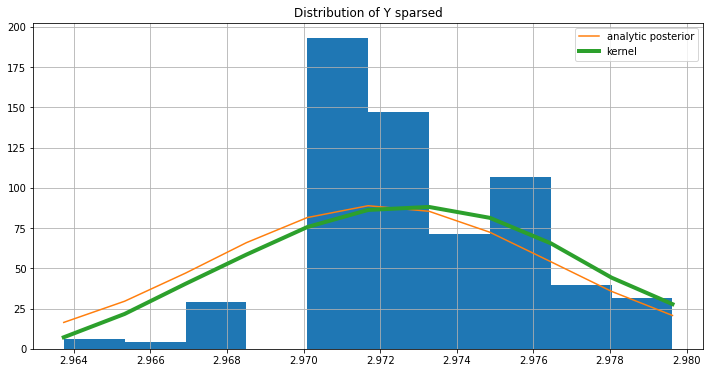

In [37]:
Y_cut_2 = Y_cut[::5]

plt.figure(figsize=(12, 6))
c, bins, _ = plt.hist(Y_cut_2, density=True)
post = analytical_posterior_pdf(bins, X, true_std, prior_mu, prior_std)
plt.plot(bins, post, label='analytic posterior')

density = KernelDensity(kernel='epanechnikov', bandwidth=0.007).fit(Y_cut_2.reshape(-1, 1))
plt.plot(bins, np.exp(density.score_samples(bins[:, None])), label='kernel', linewidth=4)
plt.title("Distribution of Y sparsed")
plt.grid()
plt.legend()
plt.show()

##### In my case, the approximations for original cutted Y and for sparsed Y (conditionally uncorrelated) are the same, no difference visually.

### Task 1.5: Posterior predictive distribution (1 bonus point)

Now that we have obtained the estimate of the posterior, we can turn to a more practical task: predicting new values $X_{n+1}$. To do it Bayesian fashoin, we employ posterior predictive distribution:
$$p(X_{n+1} | \boldsymbol{X}^{(n)}) = \int p(X_{n+1}, \mu | \boldsymbol{X}^{(n)}) d \mu = \int p(X_{n+1} | \mu, \boldsymbol{X}^{(n)}) p(\mu | \boldsymbol{X}^{(n)})d \mu = \int p(X_{n+1} | \mu) p(\mu | \boldsymbol{X}^{(n)})d \mu$$

Similar to part 1, for our simple model this distribution can also be derived analyticaly and is described on the same Wiki page.

1. Implement analytical posterior predictive distribution for our model and plot it
2. Using decorrelated samples from the posterior, obtained in the previous part, approximate the posterior predictive distribution (with histogram or KDE) and add in to the plot. Is it close to the analytocal result?

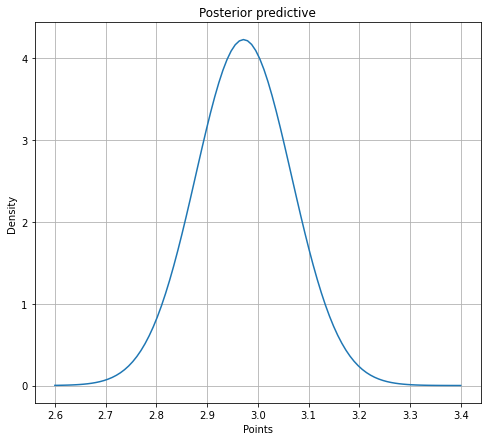

In [16]:
def posterior_predictive(x, samples, sigma, mu_0, sigma_0):

    r = 1 / (1 / sigma_0**2 + len(samples) / sigma**2)
    
    mu_p = r * (mu_0 / sigma_0**2 + np.sum(samples) / sigma**2)
    sigma_p = r
    return scipy.stats.norm(mu_p, sigma_p + sigma**2).pdf(x)   


plt.figure(figsize = (8, 7))
y = np.linspace(2.6, 3.4, 100)
plt.plot(y, posterior_predictive(y, X, true_std, prior_mu, prior_std))
plt.title('Posterior predictive')
plt.xlabel('Points')
plt.ylabel('Density')
plt.grid()
plt.show()

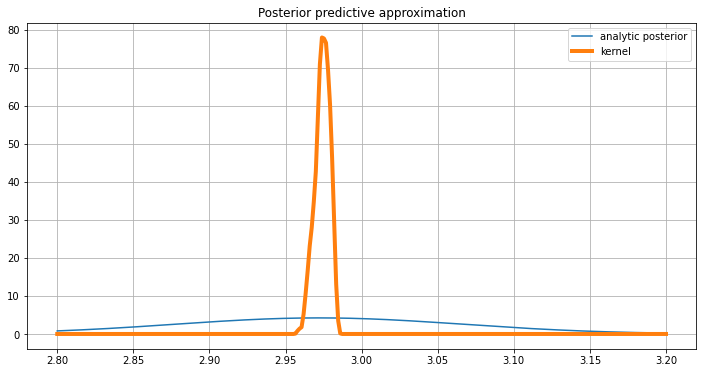

In [17]:
y = np.linspace(2.8, 3.2, len(Y_cut_2))

plt.figure(figsize=(12, 6))
post = posterior_predictive(y, X, true_std, prior_mu, prior_std)
#c, bins, _ = plt.hist(post, density=True)
plt.plot(y, post, label='analytic posterior')

density = KernelDensity(kernel='epanechnikov', bandwidth=0.007).fit(Y_cut_2.reshape(-1, 1))
#'tophat','cosine'

plt.plot(y, np.exp(density.score_samples(y[:, None])), label='kernel', linewidth=4)
plt.title("Posterior predictive approximation")
plt.grid()
plt.legend()
plt.show()

##### If I performed it right, it is not really close to the analytic result. The analytical distribution is very smooth whereas the kernel approximation has a sharp peak.

# Task 2. Substitution Cipher and Markov Chain Monte Carlo (MCMC). (5 points)

In this task we will decrypt data that was scrambled using a Substitution Cipher. We assume that encryption key is unknown and we want to decrypt the data and read the code using recovered decryption key. [Introduction from here](http://statweb.stanford.edu/~cgates/PERSI/papers/MCMCRev.pdf) gives reference to original task.

In [18]:
import string

As verification we will take a piece from "Alice's adventures in Wonderland". We scramble data with a random encryption key, which we forgot after encrypting, and we would like to decrypt this encrypted text using MCMC Chains.

In [19]:
plain_text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before see a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge.
In another moment down went Alice after it, never once considering how in the world she was to get out again.
The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well.
"""

We will use 26 letters of English alphabet.

In [20]:
characters = string.ascii_lowercase
characters_dict = {char : c for c, char in enumerate(characters, start=1)}
m = len(characters) + 1

## Generate random encryption key.

Here are functions that will be used to encrypt/decrypt text.

In [21]:
def encode_text(text_to_encode, characters_dict):
    """This function turns text string into integer sequence using given dictionary."""
    characters_set = set(characters_dict.keys())
    return np.r_[[characters_dict[char] if char in characters_set else 0 for char in text_to_encode.strip().lower()]]

def decode_text(text_to_decode, characters):
    """This function turns integer sequence into text string using given list of characters."""
    characters_array = np.array([" "] + list(characters))
    return "".join(characters_array[text_to_decode])

def apply_cipher(text_as_int_array, cipher):
    "This function applies substitution cipher to integer sequence."
    return cipher[text_as_int_array]

Generate encryption and decryption keys.

In [22]:
np.random.seed(1234)

encryption_indices = np.random.permutation(np.arange(m-1))
decryption_indices = np.argsort(encryption_indices)

characters_array = np.array(list(characters))
encryption_key = "".join(characters_array[encryption_indices])
decryption_key = "".join(characters_array[decryption_indices])

Check encoding/decoding functions and encryption/decryption keys.

In [23]:
encryption_key_encoded = np.r_[0, encode_text(encryption_key, characters_dict)]
decryption_key_encoded = np.r_[0, encode_text(decryption_key, characters_dict)]

text = "The quick brown fox jumps over the lazy dog"

encoded_text = encode_text(text, characters_dict)
cipher_text = apply_cipher(encoded_text, encryption_key_encoded)
encoded_text = apply_cipher(cipher_text, decryption_key_encoded)
decoded_text = decode_text(encoded_text, characters_dict)
decoded_text

'the quick brown fox jumps over the lazy dog'

In [24]:
encryption_key_encoded

array([ 0,  8, 17,  3,  4,  2, 19,  6,  5,  1,  9, 14, 24, 11, 25, 23, 15,
       12, 10, 18, 26, 21, 13, 22,  7, 20, 16])

Encrypt cipher text.

In [25]:
plain_text_encoded = encode_text(plain_text, characters_dict)
cipher_text = apply_cipher(plain_text_encoded, encryption_key_encoded)

## Collect frequences 

Collect frequences over large text corpus and from encrypted text.

In [26]:
def collect_transition_frequences(data, transition_matrix):
    """For a given integer sequence, which corresponds to some char sequence, 
       return transitions for adjacent values."""
    transitions = data.repeat(2)[1:-1].reshape(-1, 2)
    for i, j in transitions:
        transition_matrix[i, j] += 1
    
    return transition_matrix

def collect_empirical_frequences(filename, characters_dict, m):
    """Collect frequences over large text corpus, return transition matrix."""
    transition_matrix = np.zeros((m, m))
    with open(filename) as f:
        for line in f:
            line_encoded = encode_text(line, characters_dict)
            if line_encoded.size > 1:
                transition_matrix = collect_transition_frequences(line_encoded, transition_matrix)
                
    return transition_matrix

def collect_observed_frequences(cipher_text, characters_dict, m):
    """Collect frequences over encrypted text, return nonzero indices of 
       transition matrix for both dimentions and values for those indices.
       `values = transition_matrix[indices_1, indices_2]`"""
    transition_matrix = np.zeros((m, m))
    transition_matrix = collect_transition_frequences(cipher_text, transition_matrix)
    
    return transition_matrix

Collect frequences.

In [27]:
empirical_frequences = collect_empirical_frequences('war_and_peace.txt', characters_dict, m)
observed_frequences = collect_observed_frequences(cipher_text, characters_dict, m)

## General algorithm

Our Chain will include states that are permutations of the substitution cipher. Algorithm has following steps:

1. Start by picking up a random current state. 
2. Create a proposal for a new state by swapping two or more random letters in the current state.
3. Use a Scoring Function which calculates the score of the current state $Score_{old}$ and the proposed State $Score_{new}$.
4. If the score of the proposed state is more than current state, Move to Proposed State.
5. Else flip a coin which has a probability of Heads $\frac{Score_{new}}{Score_{old}}$  . If it comes heads move to proposed State.
6. Repeat from Step 2.

We want ot reach a steady state where the chain has the stationary distribution of the needed states. This state of chain could be used as a solution.

Let's start with implementing steps 2 and 3.

## Step 2: Prepare sampling function (2 points).



To generate a new proposed cipher we randomly select several positions and swap values at those positions. It corresponds to change in seveal mappings of encrypted characters in decrypted ones. Example with 2 swaps.

was|now
-|-
A -> B | A -> B
B -> C | B -> C
C -> D | C -> A
D -> A | D -> D

In [28]:
def generate_cipher(cipher, m, size=2):
    """Swap two or more random positions in cipher.
        
        cipher, np.array - current mapping from value(int) in encrypted text (index of array cell) into value(int) in decrypted text(value of array cell).
        m, int - capacity of used alphabet,
        size, int - number of positions to change.
    """
    
    new_cipher = cipher.copy()
    pos_swap = np.random.choice(np.arange(1, m), size=size, replace=False)
    new_values = np.array([cipher[l] for l in pos_swap])
    old_values = new_values.copy()
    while (old_values[0] == new_values[0] and old_values[1] == new_values[1]):
        random.shuffle(new_values)
    for i in range(len(pos_swap)):
        new_cipher[pos_swap[i]] = new_values[i]
    return new_cipher

In [29]:
#Example

new_cipher = generate_cipher(encryption_key_encoded, len(characters_dict) + 1, size=2)
print(encryption_key_encoded)
print(new_cipher)

[ 0  8 17  3  4  2 19  6  5  1  9 14 24 11 25 23 15 12 10 18 26 21 13 22
  7 20 16]
[ 0  8 17  3  4  2 19  6  5  1  9 14 24 11 25 23 15 12 10 18 26 21 22 13
  7 20 16]


## Step 3: Prepare scoring function (2 points).

We want to use a scoring function for each state(Decryption key) which assigns a positive score to each decryption key. This score intuitively should be larger if the encrypted text looks more like actual english, when decrypted using this decryption key. We will check large text and calculate frequences: how many times one character comes after another in a large text like "War and Peace".

For each pair of characters $\beta_1$ and $\beta_2$ (e.g. $\beta_1$ = A and $\beta_2$ = B), we let $R(\beta_1,\beta_2)$ record the number of times that specific pair(e.g. "AB") appears consecutively in the reference text.

Similarly, for a considered decryption key $x$, we let $F_x(\beta_1,\beta_2)$ record the number of times that
pair appears when the cipher text is decrypted using the decryption key $x$.

We then Score a particular decryption key $x$ using:

$$Score(x) = \prod R(\beta_1,\beta_2)^{F_x(\beta_1,\beta_2)}$$
    
To make life easier with calculations we will calculate $log(Score(x))$

Now, you need to implement scoring function. As input it takes 
- `cipher`: mapping between encrypted characters and decrypted characters,
- `observed_frequences`: transition matrix for cipher text, matrix representation of $F_x(\beta_1,\beta_2)$,
- `empirical_frequences`: transition matrix for large text, matrix representation of $R(\beta_1,\beta_2)$.

Scoring function returns $log(Score(x))$. You need correctly process zero values in transition matrices while calculating the score.

In [30]:
def score_cipher(cipher, observed_frequences, empirical_frequences):
    # Your code here
    score = 1
    for i in range(len(cipher)):
        for j in range(len(cipher)):
            b1, b2 = cipher[i], cipher[j]
            if (empirical_frequences[b1, b2] != 0):
                score += observed_frequences[i, j] * np.log(empirical_frequences[b1, b2])
    
    return score

## Decryption

Now we a ready to decrypt cipher text.

In [31]:
def decrypting(observed_frequences, empirical_frequences, n_iters, m, step_size, seed, print_it=1000):
    """This function finds most suited decrypting cipher(1D np.array).
        observed_frequences, 2D np.array - transition matrix with frequences for cipher text,
        empirical_frequences, 2D np.array - transition matrix with frequences for large text,
        n_iters, int - number of MCMC iterations,
        step_size, int - number of changes in cipher per one iteration,
        seed, int - seed for random generator,
        print_it, int - print decrypted text every `print_it` iterations.
    """

    np.random.seed(seed)

    # 1. Start by picking up a random current state. 
    cipher_old = np.arange(m)
    score_cipher_old = score_cipher(cipher_old, observed_frequences, empirical_frequences)
    best_state, score = cipher_old, score_cipher_old

    for i in tqdm(range(1, n_iters+1)):

        # 2. Create a proposal for a new state by swapping two or more random letters in the current state.
        cipher_new = generate_cipher(cipher_old, m, size=step_size)

        # 3. Use a Scoring Function which calculates the score of the current state $Score_{old}$ and the proposed State $Score_{new}$.
        score_cipher_new = score_cipher(cipher_new, observed_frequences, empirical_frequences)
        acceptance_probability = np.min((1, np.exp(score_cipher_new - score_cipher_old)))

        # 4. If the score of the proposed state is more than current state, Move to Proposed State.
        # 5. Else flip a coin which has a probability of Heads $Score_{new}/Score_{old}$. If it comes heads move to proposed State.
        if score_cipher_old > score:
            best_state, score = cipher_old, score_cipher_old
        if acceptance_probability > np.random.uniform(0,1):
            cipher_old, score_cipher_old = cipher_new, score_cipher_new
        if i % print_it == 0:
            print(f"iter {i}: {decode_text(apply_cipher(cipher_text[0:99], cipher_old), characters)}")

    return best_state

In [32]:
decrypt_cipher = decrypting(observed_frequences, empirical_frequences, 10000, m, 4, 345, 1000)

print(
    f"\nDecoded Text: {decode_text(apply_cipher(cipher_text, decrypt_cipher), characters)}\n\n"
    f"MCMC KEY  : {''.join(characters_array[decrypt_cipher[1:]-1])}\n"
    f"ACTual KEY: {decryption_key}"
)

iter 1000: alice war bedinnind to det kesy tiseg om rittind by hes rirtes on the banv  ang om hakind nothind t
iter 2000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 3000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 5000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 6000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 7000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 8000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 9000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
i

## Tuning parameters (1 point).

For step sizes in range `[2, ..., 7]`(number of pertrubations in newly generated cipher) find number of iteratoins, with `..00` precision(`print_it=100`), which is necessary to make cipher text looks more like english one. Plot obtained results.

In [33]:
for step_size in range(2, 8):
    print('For step size', step_size)
    decrypt_cipher = decrypting(observed_frequences, empirical_frequences, 10000, m, step_size, 345, 100)

For step size 2


iter 100: ivpca his qafpllplf ro far kant rpnad oj sprrplf qt ean spsran ol rea qilm  ild oj eikplf loreplf r
iter 200: impga his caypllply ro yar vanf rpnad ot sprrply cf ean spsran ol rea cilq  ild ot eivply loreply r
iter 300: impca his rakpllplk to kat vany tpnad of spttplk ry ean spstan ol tea rilg  ild of eivplk loteplk t
iter 400: imsra gip caksllslk to kat vane tsnad of psttslk ce han psptan ol tha cily  ild of hivslk lothslk t
iter 500: irsca gip maksllslk to kat vane tsnad of psttslk me han psptan ol tha mily  ild of hivslk lothslk t
iter 600: arspi gac miksllslk to kit vine tsnid of csttslk me hin csctin ol thi maly  ald of havslk lothslk t
iter 700: arspe gac meksllslk to ket veni tsned of csttslk mi hen cscten ol the maly  ald of havslk lothslk t
iter 800: arspe cag beksllslk to ket veny tsned of gsttslk by hen gsgten ol the balu  ald of havslk lothslk t
iter 900: arice pag bekissisk to ket veny tined of gittisk by hen gigten os the basu  asd of havisk sothisk t
iter 1000:

iter 100: aifkr has qrdfllfld to drt crnz tfnry ow sfttfld qz ern sfstrn ol ter qalj  aly ow eacfld lotefld t
iter 200: acnpe has rednllnld to det jefw tnfey ob snttnld rw ief snstef ol tie ralz  aly ob iajnld lotinld t
iter 300: aynce has pevnllnlv to vet jerg tnred ow snttnlv pg ier snster ol tie palk  ald ow iajnlv lotinlv t
iter 400: awnce ias peknllnlk to ket bery tnred of snttnlk py her snster ol the palv  ald of habnlk lothnlk t
iter 500: awnce ias peknllnlk to ket bery tnred of snttnlk py her snster ol the palv  ald of habnlk lothnlk t
iter 600: awnce ias peknllnlk to ket bery tnred of snttnlk py her snster ol the palv  ald of habnlk lothnlk t
iter 700: amice pas nekillilk to ket bery tired of sittilk ny her sister ol the nalv  ald of habilk lothilk t
iter 800: amice pas gekinnink to ket bery tired of sittink gy her sister on the ganv  and of habink nothink t
iter 900: amice pas lekinnink to ket wery tired of sittink ly her sister on the lanv  and of hawink nothink t
iter 1000:

iter 100: aeims uaf kshiddidh to hst xscy ticsn ow fittidh ky rsc fiftsc od trs kadp  adn ow raxidh dotridh t
iter 200: aeims uaf kshinninh to hst xsly tilsd ow fittinh ky rsl fiftsl on trs kanp  and ow raxinh notrinh t
iter 300: ahime ual pewinninw to wet xery tired ok littinw py ser lilter on tse panf  and ok saxinw notsinw t
iter 400: agime cas xewinninw to wet kery tired of sittinw xy her sister on the xanp  and of hakinw nothinw t
iter 500: apige cas lewinninw to wet mery tired of sittinw ly her sister on the lanx  and of haminw nothinw t
iter 600: alige was pevinninv to vet bery tired of sittinv py her sister on the panx  and of habinv nothinv t
iter 700: alige was pecinninc to cet bery tired of sittinc py her sister on the panx  and of habinc nothinc t
iter 800: alige was pecinninc to cet very tired of sittinc py her sister on the panx  and of havinc nothinc t
iter 900: alige was pecinninc to cet very tired of sittinc py her sister on the panx  and of havinc nothinc t
iter 1000:

iter 100: noaje inu leraccacr st res begh saged ty uassacr lh meg uauseg tc sme lncp  ncd ty mnbacr ctsmacr s
iter 200: nvaue onh lekaccack st kes beig saied ty hassack lg mei hahsei tc sme lncr  ncd ty mnback ctsmack s
iter 300: ovaue fom cekallalk st kes benh saned ty massalk ch ien mamsen tl sie colg  old ty iobalk ltsialk s
iter 400: obaie por ceyallaly su yes zenv saned um rassaly cv ten rarsen ul ste colf  old um tozaly lustaly s
iter 500: ogaie por ceyallaly su yes zenf saned um rassaly cf ten rarsen ul ste colb  old um tozaly lustaly s
iter 600: ogaie por ceyallaly su yes zenf saned um rassaly cf ten rarsen ul ste colb  old um tozaly lustaly s
iter 700: ogaie por ceyallaly su yes henw saned um rassaly cw ten rarsen ul ste colf  old um tohaly lustaly s
iter 800: ogaie por ceyallaly su yes venw saned um rassaly cw ten rarsen ul ste colf  old um tovaly lustaly s
iter 900: ogace bor keyallaly su yes venw saned um rassaly kw ten rarsen ul ste kolf  old um tovaly lustaly s
iter 1000:

iter 100: lxowr bla qrfoiioif nu frn mrpy noprd ut aonnoif qy erp aoanrp ui ner qlic  lid ut elmoif iuneoif n
iter 200: suadr ksh vrfaiiaif no frn xrmp namrc ot hannaif vp erm hahnrm oi ner vsib  sic ot esxaif ioneaif n
iter 300: sladr gsh brvaiiaiv no vrn wryj nayrf ot hannaiv bj ery hahnry oi ner bsiu  sif ot eswaiv ioneaiv n
iter 400: spacr ysd mrwallalw to wrt vrik tairf oh dattalw mk eri dadtri ol ter mslg  slf oh esvalw lotealw t
iter 500: spacr ysd mrwallalw to wrt vrik tairf oh dattalw mk eri dadtri ol ter mslg  slf oh esvalw lotealw t
iter 600: ilace yid neparrarp to pet vemk tamef oh dattarp nk sem dadtem or tse nirw  irf oh sivarp rotsarp t
iter 700: ilace pid bewannanw to wet vemk tamey or dattanw bk sem dadtem on tse binh  iny or sivanw notsanw t
iter 800: ilace pid bewannanw to wet vemk tamey or dattanw bk sem dadtem on tse binh  iny or sivanw notsanw t
iter 900: alice pad bewimmimw to wet venk tiney or dittimw bk sen didten om tse bamh  amy or savimw motsimw t
iter 1000:

iter 100: tplde cty fexlnnlnx so xes geik sliea ou ylsslnx fk mei ylysei on sme ftnh  tna ou mtglnx nosmlnx s
iter 200: lhade gly tebannanb so bes feri sarep ow yassanb ti mer yayser on sme tlnq  lnp ow mlfanb nosmanb s
iter 300: rcade tri hefannanf so fes qelv salep ow iassanf hv mel iaisel on sme hrng  rnp ow mrqanf nosmanf s
iter 400: rcade tri hefannanf so fes qelv salep ow iassanf hv mel iaisel on sme hrng  rnp ow mrqanf nosmanf s
iter 500: rcade pri gefannanf so fes kelh salet ow iassanf gh mel iaisel on sme grnj  rnt ow mrkanf nosmanf s
iter 600: rcade pri gefannanf so fes kelh salet ow iassanf gh mel iaisel on sme grnj  rnt ow mrkanf nosmanf s
iter 700: rcade pri gefannanf so fes kelh salet ow iassanf gh mel iaisel on sme grnj  rnt ow mrkanf nosmanf s
iter 800: rcade pri gefannanf so fes kelh salet ow iassanf gh mel iaisel on sme grnj  rnt ow mrkanf nosmanf s
iter 900: rcade pri gefannanf so fes yelh salet ow iassanf gh mel iaisel on sme grnk  rnt ow mryanf nosmanf s
iter 1000:

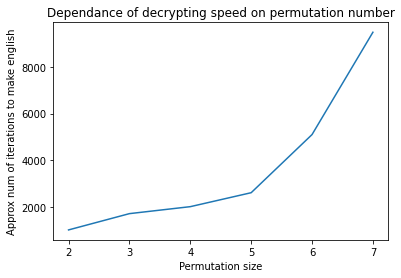

In [34]:
perm_sizes = np.arange(2, 8)
num_iters = np.array([1000, 1700, 2000, 2600, 5100, 9500]) #2600 ->3300

plt.plot(perm_sizes, num_iters)
plt.title('Dependance of decrypting speed on permutation number')
plt.xlabel('Permutation size')
plt.ylabel('Approx num of iterations to make english')
plt.show()